<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [445]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [446]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [447]:
data, attrs = fetch_dataset()

In [448]:
data.shape

(13143, 64, 64, 3)


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

Training input shape:  (10514, 64, 64, 3)


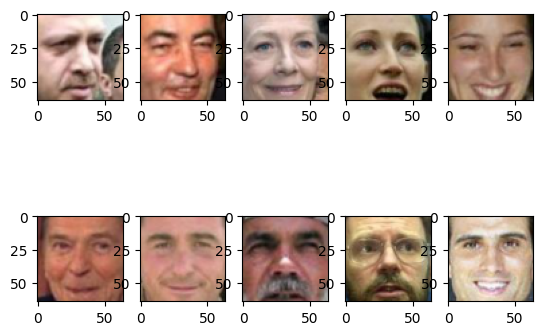

(64, 64, 3)


In [449]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, attrs, test_size=0.2, random_state=42)
print("Training input shape: ", X_train.shape)

fig, axs = plt.subplots(2, 5)
for i in range(2):
  for j in range(5):
    axs[i, j].imshow(X_train[i*5+j])
plt.show()

print(X_train[0].shape)

In [450]:
import torchvision.transforms as transforms

transform = transforms.ToTensor()

X_train = torch.stack([transform(img) for img in X_train])
X_train = X_train.permute(0, 2, 3, 1)

X_test = torch.stack([transform(img) for img in X_test])
X_test = X_test.permute(0, 2, 3, 1)

print('X_train type:', type(X_train))
print('X_train shape:', X_train.shape)

print('y_train type:', type(y_train))
print('y_train shape:', y_train.shape)

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([10514, 64, 64, 3])
y_train type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (10514, 73)


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [451]:
dim_code = 30 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [452]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(30, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

    def sample(self, z):
        generated = self.decoder(z)
        return generated

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [454]:
from torch.utils.data import TensorDataset

train_loader = torch.utils.data.DataLoader(X_train, batch_size=4)
val_loader = torch.utils.data.DataLoader(X_test, batch_size=4)

In [455]:
from tqdm import tqdm_notebook

n_epochs = 15
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

model = Autoencoder().to(device, dtype=torch.float)

cpu


In [456]:
model = Autoencoder().to(device, dtype=torch.float)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for X_batch in train_loader:
      optimizer.zero_grad()
      X_batch = X_batch.permute(0, 3, 1, 2)
      # print(X_batch.to(device, dtype=torch.float).shape)
      reconstructed = model.forward(X_batch.to(device, dtype=torch.float))
      loss = loss_fn(reconstructed, X_batch.to(device, dtype=torch.float))
      loss.backward()
      optimizer.step()
      train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          X_batch = X_batch.permute(0, 3, 1, 2)
          reconstructed = model.forward(X_batch.to(device, dtype=torch.float))
          loss = loss_fn(reconstructed, X_batch.to(device, dtype=torch.float))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

<ipython-input-456-697b3a7be04a>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

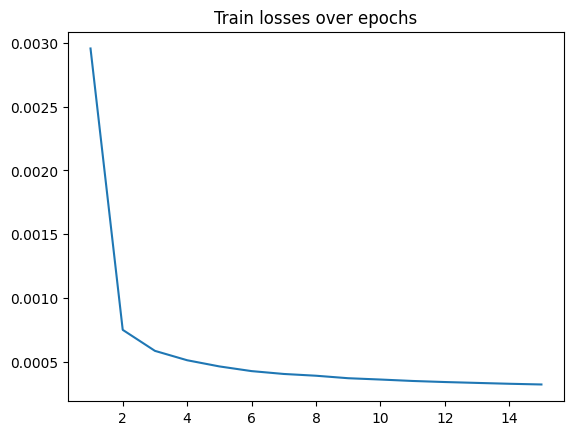

In [457]:
# print("train_losses", train_losses)
plt.title("Train losses over epochs")
plt.plot(range(1, n_epochs + 1), train_losses)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [458]:
model.eval()

n_images = 4

data = next(iter(val_loader))
inputs = data[:n_images]
inputs = inputs.permute(0, 3, 2, 1)

data.shape

torch.Size([4, 64, 64, 3])

torch.Size([4, 3, 64, 64])


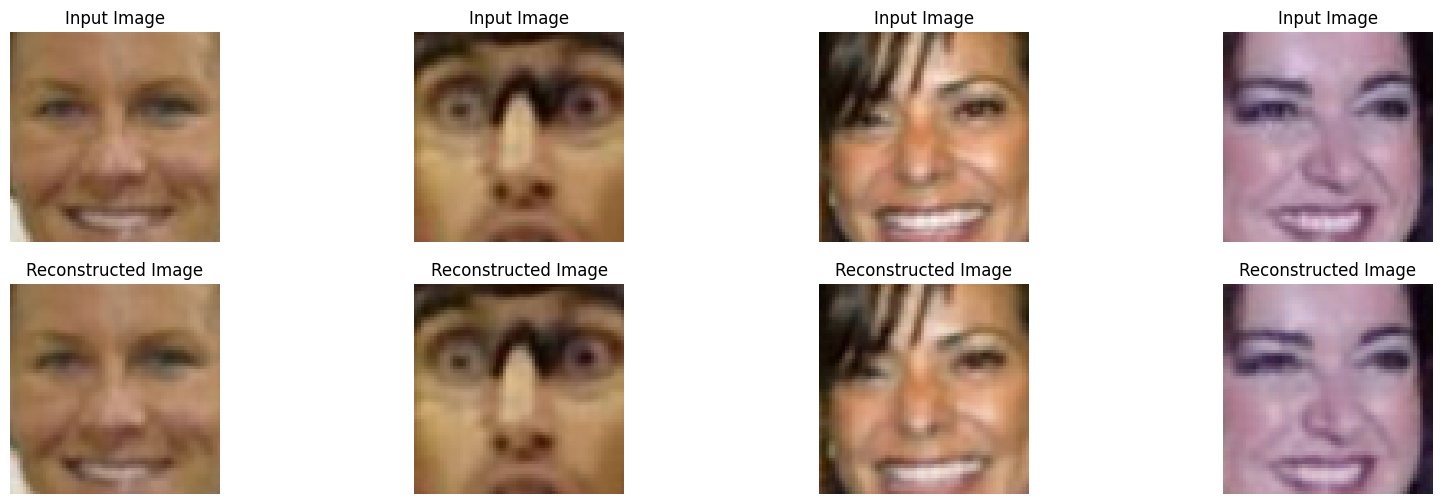

In [459]:
reconstructed = model(inputs.to(device, dtype=torch.float))
print(reconstructed.shape)

inputs = inputs.permute(0, 3, 2, 1)
reconstructed = reconstructed.permute(0, 3, 2, 1)

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 6))

for i in range(n_images):
    axes[0, i].imshow(inputs[i])
    with torch.no_grad():
      axes[1, i].imshow(reconstructed[i])

    axes[0, i].axis('off')
    axes[1, i].axis('off')

    axes[0, i].set_title('Input Image')
    axes[1, i].set_title('Reconstructed Image')

plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [460]:
inputs = next(iter(train_loader))
results = model.encoder(inputs.permute(0,3,1,2).float())
results.shape

means = []
stds = []
for i in range(len(inputs)):
  means.append(torch.mean(results[i].reshape(7680, 1)).detach().numpy())
  stds.append(torch.std(results[i].reshape(7680, 1)).detach().numpy())

In [461]:
means

[array(0.33223072, dtype=float32),
 array(0.295804, dtype=float32),
 array(0.31488788, dtype=float32),
 array(0.29802212, dtype=float32)]

In [462]:
stds

[array(0.29978633, dtype=float32),
 array(0.2584865, dtype=float32),
 array(0.2709733, dtype=float32),
 array(0.25689384, dtype=float32)]

torch.Size([30, 16, 16])
torch.Size([64, 64, 3])


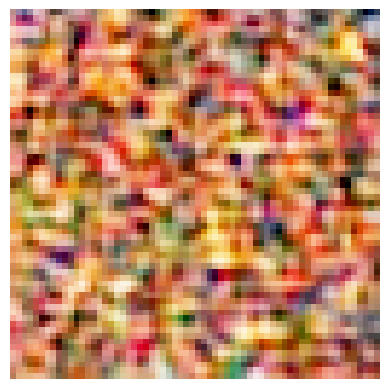

In [463]:
z = torch.normal(0.3303317, 0.268295, (30, 16, 16)).to(device).float()
print(z.shape)

with torch.no_grad():
  generated = model.decoder(z)
generated = generated.permute(2, 1, 0)
generated = generated.detach().cpu().squeeze()

import matplotlib.pyplot as plt

print(generated.shape)
plt.imshow(generated)
plt.axis('off')
plt.show()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [464]:
data, attrs = fetch_dataset()

In [465]:
print(attrs.columns)

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [466]:
smiling_people = attrs.sort_values(['Smiling'])[-1000:-100]

smiling_images = []
non_smiling_images = []

for smile_index in np.sort(np.array(smiling_people.index)):
  smiling_images.append(data[smile_index])
smiling_images = torch.tensor(smiling_images).float()
with torch.no_grad():
    smiling_latent = model.encoder(smiling_images.permute(0, 3, 2, 1)).view(len(smiling_images), -1)

non_smiling_people = attrs.sort_values(['Smiling'])[100:1000]

for non_smile_index in np.sort(np.array(non_smiling_people.index)):
  non_smiling_images.append(data[non_smile_index])

non_smiling_images = torch.tensor(non_smiling_images).float()
with torch.no_grad():
    non_smiling_latent = model.encoder(non_smiling_images.permute(0, 3, 2, 1)).view(len(non_smiling_images), -1)

avg_smiling_latent = torch.mean(smiling_latent, dim=0)
avg_non_smiling_latent = torch.mean(non_smiling_latent, dim=0)

smile_vector = avg_smiling_latent - avg_non_smiling_latent

torch.Size([1, 7680])


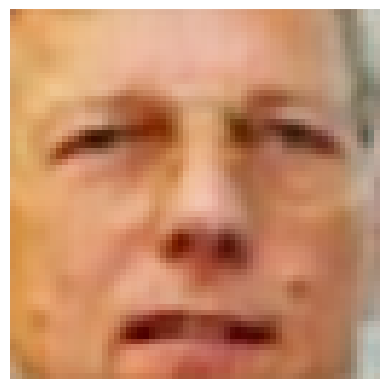

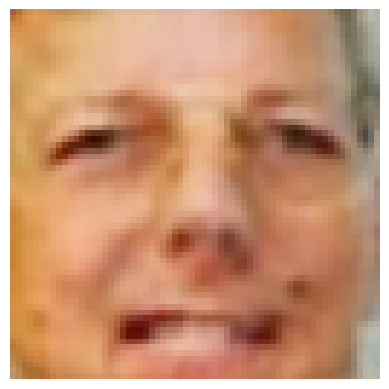

In [467]:
idx = np.sort(np.array(non_smiling_people.index))[np.random.choice(len(non_smiling_people))]
image = torch.tensor(data[idx]).float().unsqueeze(0).permute(0, 3, 2, 1)
with torch.no_grad():
    latent = model.encoder(image).view(1, -1)
    smiling_latent = latent + smile_vector.unsqueeze(0)
    print(latent.shape)
    rnd_image_reconstructed = model.decoder(latent.view(1, 30, 16, 16))
    smiling_image = model.decoder(smiling_latent.view(1, 30, 16, 16))

plt.imshow(rnd_image_reconstructed[0].permute(2, 1, 0))
plt.axis('off')
plt.show()

plt.imshow(smiling_image[0].permute(2, 1, 0))
plt.axis('off')
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [468]:
batch_size = 32

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

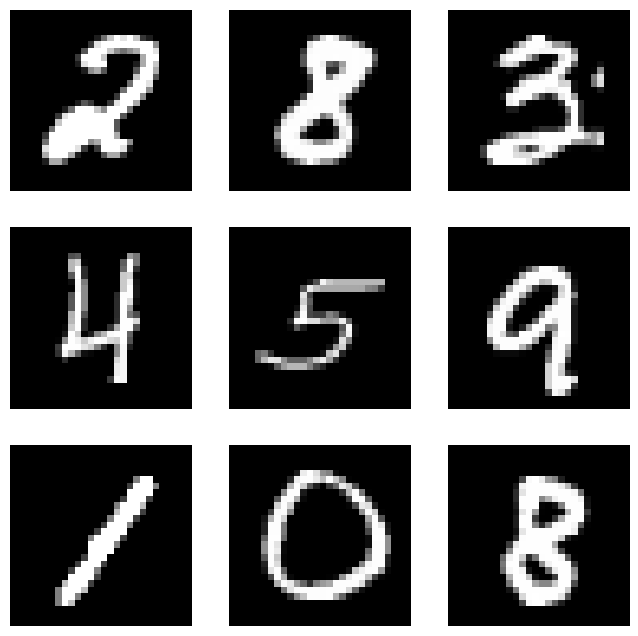

In [469]:
images, _ = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, image in zip(axes.flatten(), images):
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.grid(False)
    ax.set_axis_off()

plt.show()

<class 'numpy.ndarray'>


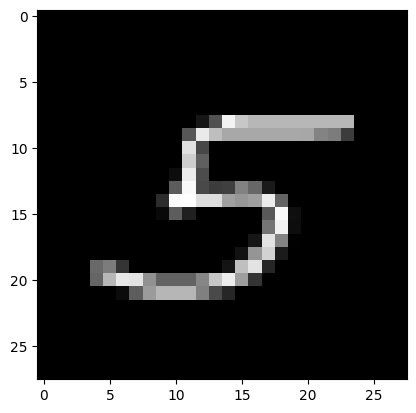

In [470]:
print(type(images[1].squeeze().numpy()))
plt.imshow(images[4].view(28, 28), cmap='gray')

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [471]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, image_shape, dropout=0.3):
        super().__init__()

        in_features = np.prod(image_shape)
        encoder_modules = [nn.Flatten()]
        for out_features in intermediate_dims:
            encoder_modules.append(nn.Linear(in_features, out_features))
            encoder_modules.append(nn.ReLU())
            encoder_modules.append(nn.BatchNorm1d(out_features))
            encoder_modules.append(nn.Dropout(dropout))

            in_features = out_features
        
        self.encoder = nn.Sequential(*encoder_modules)

        self.latent_mu = nn.Linear(in_features, latent_dim)
        self.latent_log_sigma = nn.Linear(in_features, latent_dim)
        
        in_features = latent_dim
        decoder_modules = []
        for out_features in reversed(intermediate_dims):
            decoder_modules.append(nn.Linear(in_features, out_features))
            decoder_modules.append(nn.LeakyReLU())
            decoder_modules.append(nn.BatchNorm1d(out_features))
            decoder_modules.append(nn.Dropout(dropout))

            in_features = out_features

        out_features = np.prod(image_shape)
        decoder_modules.append(nn.Linear(in_features, out_features))

        decoder_modules.append(nn.Sigmoid())
        decoder_modules.append(nn.Unflatten(dim=1, unflattened_size=image_shape))
        self.decoder = nn.Sequential(*decoder_modules)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        return sample
 
    def reparametrize(self, sample, mu, log_sigma):
        # YOUR CODE HERE
        # latent_sample = ...
        latent_sample = torch.exp(log_sigma) * sample + mu
        return latent_sample

    def forward(self, x):
        encoded = self.encoder(x)
        latent_mu = self.latent_mu(encoded)
        latent_log_sigma = self.latent_log_sigma(encoded)
        
        sample = torch.randn_like(latent_mu)
        latent_sample = self.reparametrize(sample, latent_mu, latent_log_sigma)
        
        reconstructed = self.decoder(latent_sample)
        return reconstructed, latent_sample, latent_mu, latent_log_sigma

In [472]:
from torchsummary import summary

images = images.to(device)
image_shape = images[0].shape
print("image_shape = ", image_shape)
latent_dim = 20

model = VariationalAutoEncoder(
    intermediate_dims=[256, 128], 
    latent_dim=latent_dim, 
    image_shape=image_shape,
).to(device)
optimizer = torch.optim.Adam(model.parameters())

reconstructed, latent_sample, mu, log_sigma = model(images)
summary(model, image_shape)

image_shape =  torch.Size([1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
       BatchNorm1d-8                  [-1, 128]             256
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 20]           2,580
           Linear-11                   [-1, 20]           2,580
           Linear-12                  [-1, 128]           2,688
        LeakyReLU-13                  [-1, 128]               0


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [473]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    sigma = torch.exp(logsigma)
    return 0.5 * torch.mean(
        torch.sum(mu * mu + sigma * sigma - 2 * logsigma - 1, dim=1)
    )

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    bce_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return -bce_loss

def loss_vae(x, mu, logsigma, reconstruction):
    kl_loss = KL_divergence(mu, logsigma)
    log_likelihood_loss = log_likelihood(x, reconstruction)
    return kl_loss + log_likelihood_loss

In [474]:
def get_test_predictions(model, test_loader):
    reconstructed_batches = []
    latent_sample_batches = []
    mu_batches = []
    log_sigma_batches = []

    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(test_loader, leave=False):
            images = images.to(device)
            reconstructed, latent_sample, mu, log_sigma = model(images)
            reconstructed_batches.append(reconstructed.cpu())
            latent_sample_batches.append(latent_sample.cpu())
            mu_batches.append(mu.cpu())
            log_sigma_batches.append(log_sigma.cpu())

    reconstructed = torch.cat(reconstructed_batches, dim=0)
    latent_sample = torch.cat(latent_sample_batches, dim=0)
    mu = torch.cat(mu_batches, dim=0)
    log_sigma = torch.cat(log_sigma_batches, dim=0)
    return reconstructed, latent_sample, mu, log_sigma

И обучим модель:

In [475]:
criterion = loss_vae

model = VariationalAutoEncoder(intermediate_dims=[256, 128], 
    latent_dim=latent_dim, 
    image_shape=image_shape,).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [476]:
from scipy.stats import norm

def draw_manifold(model, image_shape, n_steps=15):
    model.eval()

    _, _, image_height, image_width = image_shape
    manifold = np.zeros((image_height * n_steps, image_width * n_steps, 3))

    grid_x = norm.ppf(np.linspace(0.05, 0.95, n_steps))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n_steps))
    coords = np.stack(np.meshgrid(grid_x, grid_y), axis=-1)
    coords = coords.reshape(-1, 2)
    coords = np.hstack((coords, np.zeros((n_steps**2, 20-2))))

    with torch.no_grad():
        decoded_images = model.decoder(torch.from_numpy(coords).float().to(device)).cpu().numpy()

    decoded_images = decoded_images.reshape(-1, *image_shape)

    for i in range(n_steps):
        for j in range(n_steps):
            manifold[i * image_height : (i + 1) * image_height,
                     j * image_width : (j + 1) * image_width] = decoded_images[i*n_steps+j]

    return manifold



In [477]:
from tqdm.auto import tqdm, trange

n_epochs = 10
epochs, manifolds, latent_distributions = [], [], []
bce_loss = F.binary_cross_entropy
for epoch in trange(n_epochs):
    model.train()
    train_loss = 0.
    train_bce = 0.
    train_kl = 0.
    for images, _ in tqdm(train_loader, leave=False):
        images = images.to(device)
        reconstructed, latent_sample, mu, log_sigma = model(images)

        bce = bce_loss(reconstructed, images)
        kl = KL_divergence(mu, log_sigma)
        loss = loss_vae(images, mu, log_sigma, reconstructed)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kl += kl.item()

    train_loss /= len(train_loader)
    train_bce /= len(train_loader)
    train_kl /= len(train_loader)

    if epoch % 5 == 0:
        print(f'epoch {epoch}: loss={train_loss:.4f}, kl={train_kl:.4f}, bce={train_bce:.4f}')

        epochs.append(epoch)

        model.eval()
        _, _, mu, _ = get_test_predictions(model, test_loader)
        latent_distributions.append(mu)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 0: loss=-1601506.9011, kl=7342.7644, bce=64.1283


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 5: loss=-2156189.8559, kl=165.4856, bce=85.9517


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

  0%|          | 0/313 [00:00<?, ?it/s]

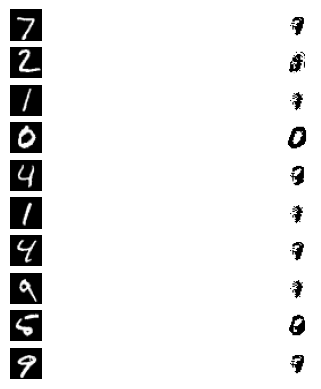

In [478]:
X = 10
model.eval()
i = 0
num_rows = X
num_cols = 2

with torch.no_grad():
    for images, _ in tqdm(test_loader, leave=False):
          if i >= X:
                break

          images = images.to(device)
          reconstructed, latent_sample, mu, log_sigma = model(images)
          for j in range(10):
            plt.subplot(num_rows, num_cols, 2*j+1)
            plt.imshow(images[j].squeeze().numpy(), cmap='gray')
            plt.axis('off')
            plt.subplot(num_rows, num_cols, 2*j+2)
            plt.imshow(reconstructed[j].squeeze().numpy(), cmap='gray')
            plt.axis('off')
            i += 1

          
    plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [479]:
vae = VariationalAutoEncoder([512, 256, 128], 20, (3, 32, 32))
vae.eval()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=512, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.3, inplace=False)
  )
  (latent_mu): Linear(in_features=128, out_features=20, bias=True)
  (latent_log_sigma): Linear(in_features=128, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Batc

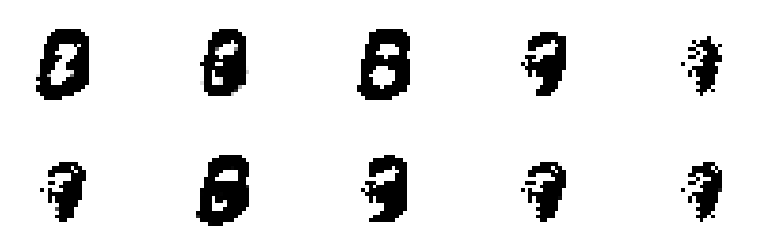

In [480]:
z = np.array([np.random.normal(0, 1, 20) for i in range(10)])

z = torch.tensor(z).float()

output = model.decoder(z).cpu().detach().numpy()

fig = plt.figure(figsize=(10, 3))
for j in range(10):
    plt.subplot(2, 5, j+1)
    plt.imshow(output[j].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

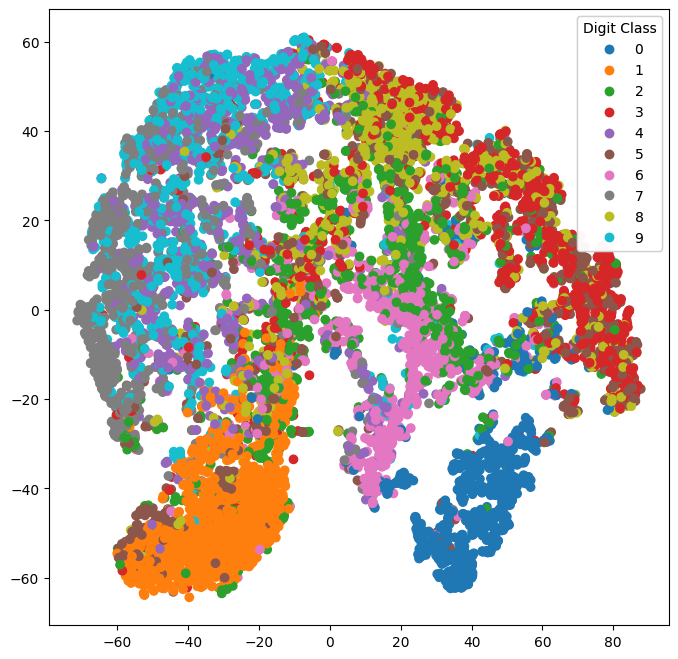

In [481]:
import torchvision
from sklearn.manifold import TSNE

with torch.no_grad():
    test_latent_samples = []
    test_labels = []
    for images, labels in test_loader:
        reconstructed_images, latent_samples, _, _ = model(images)
        test_latent_samples.append(latent_samples)
        test_labels.append(labels)
    test_latent_samples = torch.cat(test_latent_samples, axis=0)
    test_labels = torch.cat(test_labels, axis=0)

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
test_latent_samples_2d = tsne.fit_transform(test_latent_samples)

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(test_latent_samples_2d[:, 0], test_latent_samples_2d[:, 1], c=test_labels, cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(), title="Digit Class")
ax.add_artist(legend1)
plt.show()

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [482]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, class_num=10, latent_dim=10, hidden_dims=[256, 64]):
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + class_num, hidden_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[1]),
        )
        
        self.mu_layer = nn.Linear(hidden_dims[1], latent_dim)
        self.logsigma_layer = nn.Linear(hidden_dims[1], latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + class_num, hidden_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        hidden = self.encoder(inputs)
        mu = self.mu_layer(hidden)
        logsigma = self.logsigma_layer(hidden)
        return mu, logsigma, y

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, y):
        inputs = torch.cat([z, y], dim=1)
        return self.decoder(inputs)

    def forward(self, x, y):
        mu, logsigma, _ = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        return mu, logsigma, self.decode(z, y)

In [489]:
input_dim = 784
class_num = 10
latent_dim = 10 
hidden_dims = [512, 256, 64]
batch_size = 128
learning_rate = 0.001

cvae = CVAE(input_dim, class_num, latent_dim, hidden_dims)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae.to(device)

optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0
    cvae.train()

    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(x.size(0), -1)
        x = x.to(device)
        y = F.one_hot(y, num_classes=class_num).float()
        y = y.to(device)

        optimizer.zero_grad()

        mu, logsigma, x_hat = cvae(x, y)
        kl_divergence = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

        loss = criterion(x_hat, x) + 0.01 * kl_divergence
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    print('Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

Epoch: 1 Average loss: 121.3279
Epoch: 2 Average loss: 96.0082
Epoch: 3 Average loss: 92.4252
Epoch: 4 Average loss: 90.2474
Epoch: 5 Average loss: 88.8026
Epoch: 6 Average loss: 87.6928
Epoch: 7 Average loss: 86.6996
Epoch: 8 Average loss: 86.1216
Epoch: 9 Average loss: 85.4419
Epoch: 10 Average loss: 84.8700


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

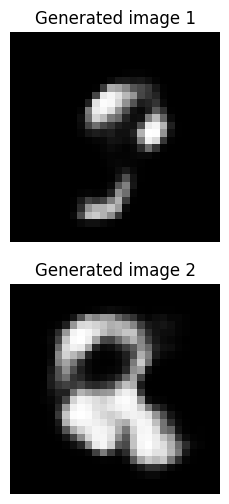

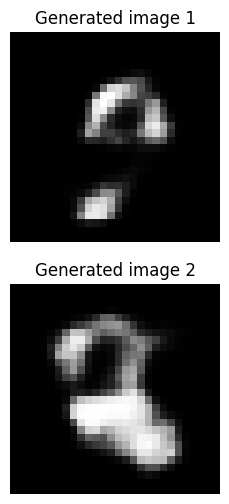

In [491]:
class_num = 10

label_5 = torch.tensor([5])
label_7 = torch.tensor([7])

label_5 = F.one_hot(label_5, num_classes=class_num).float()
label_7 = F.one_hot(label_7, num_classes=class_num).float()

z = torch.randn(2, 10)

label_5 = label_5.repeat(2, 1)  # repeat along first dimension
label_7 = label_7.repeat(2, 1)  # repeat along first dimension

sample_5 = cvae.decode(z, label_5)
sample_7 = cvae.decode(z, label_7)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

for i in range(2):
    img = sample_5[i].view(28, 28).detach().numpy()
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('Generated image {}'.format(i+1))
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

for i in range(2):
    img = sample_7[i].view(28, 28).detach().numpy()
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('Generated image {}'.format(i+1))
    ax[i].axis('off')

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

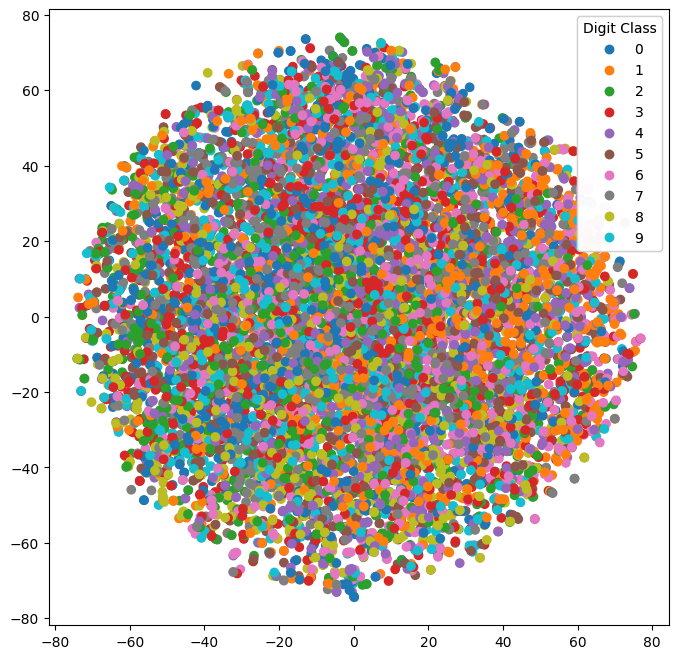

In [485]:
def find_latent_representation_cvae(model, data_loader, device):
    with torch.no_grad():
        latent_samples = []
        labels = []
        for images, labels_batch in data_loader:
            images = images.view(images.size(0), -1)
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            label_onehot = F.one_hot(labels_batch, num_classes=10).float()
            mu, logsigma, _ = model.encode(images, label_onehot)
            z = model.gaussian_sampler(mu, logsigma)
            latent_samples.append(z)
            labels.append(labels_batch)
        latent_samples = torch.cat(latent_samples, axis=0)
        labels = torch.cat(labels, axis=0)
    return latent_samples, labels

test_latent_samples, test_labels = find_latent_representation_cvae(cvae, test_loader, device)

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
test_latent_samples_2d = tsne.fit_transform(test_latent_samples.cpu().numpy())

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(test_latent_samples_2d[:, 0], test_latent_samples_2d[:, 1], c=test_labels.cpu().numpy(), cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(), title="Digit Class")
ax.add_artist(legend1)
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Заметно отличается

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>